<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Neural%20ML/Tandem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
from copy import deepcopy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Модели
import torch
import torch.nn as nn

# Метрики качества
from time import time

from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install torchmetrics
from torchmetrics import R2Score

!pip install torcheval
from torcheval.metrics.functional import r2_score

#!pip install onnx
#!pip install hiddenlayer
#import hiddenlayer as hl
!pip install torchview
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

# Обработка датасета
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Нормировка датасета
from sklearn.preprocessing import RobustScaler, StandardScaler

# Удобства
from tqdm import tqdm

# Шедуллер
from torch.optim.lr_scheduler import ReduceLROnPlateau

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 6.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 10.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Фиксация сида:

In [ ]:
import random

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

Перенос модели на GPU:

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Подготовка данных

## Скачивание данных и скриптов

Загружаем датасет с GitHub:

In [ ]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-05-23 13:11:26--  https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main [following]
--2023-05-23 13:11:26--  https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [       <=>          ]  15.46M  6.63MB/s    in 2.3s    

2023-05-23 13:11:29 (6.63 MB/s) - ‘/tmp/data.zip’ saved [16209937]



In [ ]:
%cd '/tmp/nems_ai-main/Data Processed'
filename = 'Dataset_Processed.csv'
df = pd.read_csv(filename)
df = df.drop(columns='Unnamed: 0')
df.head()

/tmp/nems_ai-main/Data Processed


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,10.666186,759.454713,192.911166,46.497924,19.089801,465.822644,28.323179,9.003567e+08,6.415102e+07,1.336133e+04,...,2.909667e+08,1.143351e+04,2.560363e-15,6.037978e-22,3.409430e-12,3.964520e+08,1.013999e+04,8.780197e-16,3.181145e-22,4.959458e-12
1,105.195552,890.696186,209.252268,37.407275,3.716553,314.636835,30.305477,5.090849e+08,2.569354e+06,7.177442e+06,...,8.224139e+06,5.740452e+06,3.281744e-14,8.720428e-28,1.367533e-11,1.152226e+07,5.003229e+06,3.291971e-14,1.406151e-27,1.583936e-11
2,10.310316,221.113532,195.903798,37.079461,0.027053,251.500693,26.675832,6.351363e+08,3.353110e+07,2.675673e+06,...,1.267642e+08,1.891218e+06,7.206070e-16,6.788349e-28,2.254001e-12,1.923697e+08,1.709827e+06,7.147747e-16,1.130223e-27,2.477637e-12
3,18.683573,282.662136,207.614117,18.750307,0.496423,172.245797,2.647445,0.000000e+00,1.049078e+07,8.772643e+06,...,4.475571e+07,8.332783e+06,1.623836e-15,6.849769e-28,2.943955e-12,7.057576e+07,8.000998e+06,1.616668e-15,1.119973e-27,3.081568e-12
4,121.747842,991.550766,102.506945,29.297485,2.037235,415.471216,18.419812,8.374213e+08,2.649739e+06,7.314592e+06,...,8.269131e+06,6.082613e+06,2.259615e-14,2.331664e-28,2.518650e-11,1.138111e+07,5.405428e+06,2.267905e-14,3.624442e-28,2.982471e-11


## Скейлинг

Делаем несколько действий:
- разбиваем датасет на тренировочную + валидационную часть и тестовую часть
- разбиваем трен-вал датасет на X и Y данные
- разбиваем тест датасет на X и Y данные

In [ ]:
len_test = 0.2 # доля объектов на тренировку и валидацию из изначального датасета
len_val = 0.2 # доля объектов на валидацию из трен-вал датасета

df_trainval, df_test = train_test_split(df, test_size=len_test, random_state=42, shuffle=True)
df_train, df_val = train_test_split(df_trainval, test_size=len_val, random_state=42, shuffle=True)

Разбиение подвыборок на X и Y данные. Внимание: здесь берутся только два первых параметра из двадцати.

In [ ]:
%cd '/tmp/nems_ai-main/Scripts'
from dataset_preprocessing_pandas import split_df

x_train, y_train = split_df(df_train, num_common=8)
x_val, y_val = split_df(df_val, num_common=8)
x_test, y_test = split_df(df_test, num_common=8)

# Берем лишь один параметр из двадцати
x_train, y_train = x_train.iloc[:], y_train.iloc[:, :1]
x_val, y_val = x_val.iloc[:], y_val.iloc[:, :1]
x_test, y_test = x_test.iloc[:], y_test.iloc[:, :1]

print('Dataset has been split into parts with the following shapes:')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

/tmp/nems_ai-main/Scripts
Dataset has been split into parts with the following shapes:
x_train: (3141, 8)
y_train: (3141, 1)
x_val: (786, 8)
y_val: (786, 1)
x_test: (982, 8)
y_test: (982, 1)


In [ ]:
x_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa)
4153,49.308200,782.896481,188.132818,26.635533,39.776275,218.106779,14.971359,3.142405e+08
3543,192.137428,518.376180,207.654824,15.361588,14.690520,358.705745,17.274668,0.000000e+00
907,58.299798,519.390602,200.345532,16.901881,264.175611,263.652628,23.487618,0.000000e+00
2522,65.228068,534.583721,199.844154,17.919077,10.055709,590.683389,30.865407,5.533608e+08
3107,419.836754,346.292481,209.354864,44.989361,1.196841,283.956739,17.091576,3.264575e+08


In [ ]:
y_train.head()

,M1 Eigenfrequency (Hz)
3781,8.234588e+05
2200,3.620573e+07
4798,4.018177e+06
963,4.495736e+07
3965,3.016408e+06


Выполняем логарифмирование и скейлинг:

In [ ]:
from dataset_preprocessing_pandas import Scaler as Scaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

mode_number = 1
log_params = ['Eigenfrequency (Hz)']
s = Scaler(scaler_x, scaler_y, mode_number)
s.fit(x_train, y_train, log_params)

x_train, y_train = s.transform(x_train, y_train)
x_val, y_val = s.transform(x_val, y_val)
x_test, y_test = s.transform(x_test, y_test)

In [ ]:
y_test.describe()

,M1 Eigenfrequency (Hz)
count,982.000000
mean,0.008397
std,0.988296
min,-2.210503
25%,-0.764214
50%,-0.023415
75%,0.712678
max,2.345348


## Визуализация распределения нормированных параметров

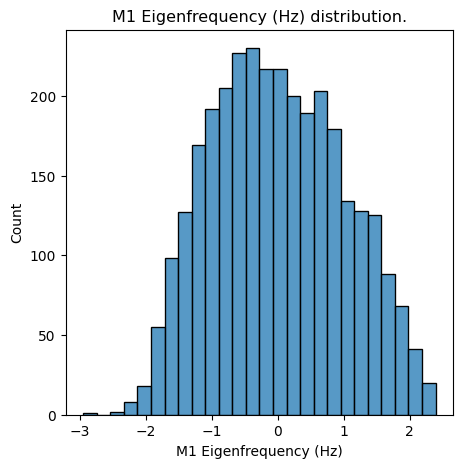

In [ ]:
from classic_ml import plot_distribution

plot_distribution(df=y_train, param_name='Eigenfrequency (Hz)',
                  log_scale=False, font_size=0.25, modes=[1])

## Формирование подвыборок

Определение подвыборок и даталоадеров:

In [ ]:
from dataset_preprocessing_torch import CustomDataset

trainset = CustomDataset(x_train, y_train)
valset = CustomDataset(x_val, y_val)
testset = CustomDataset(x_test, y_test)

batch_size = 64

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
print(len(train_loader))

50


# Forward модель (Fully Connected)

In [ ]:
num_pars_x = x_train.shape[1]
num_pars_y = y_train.shape[1]

class FCNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=num_pars_x, out_features=1000, bias=False),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=200, bias=False),
            nn.BatchNorm1d(num_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=num_pars_y, bias=True),
        )
    
    def forward(self, x):
        out = self.network(x)
        return out
    
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

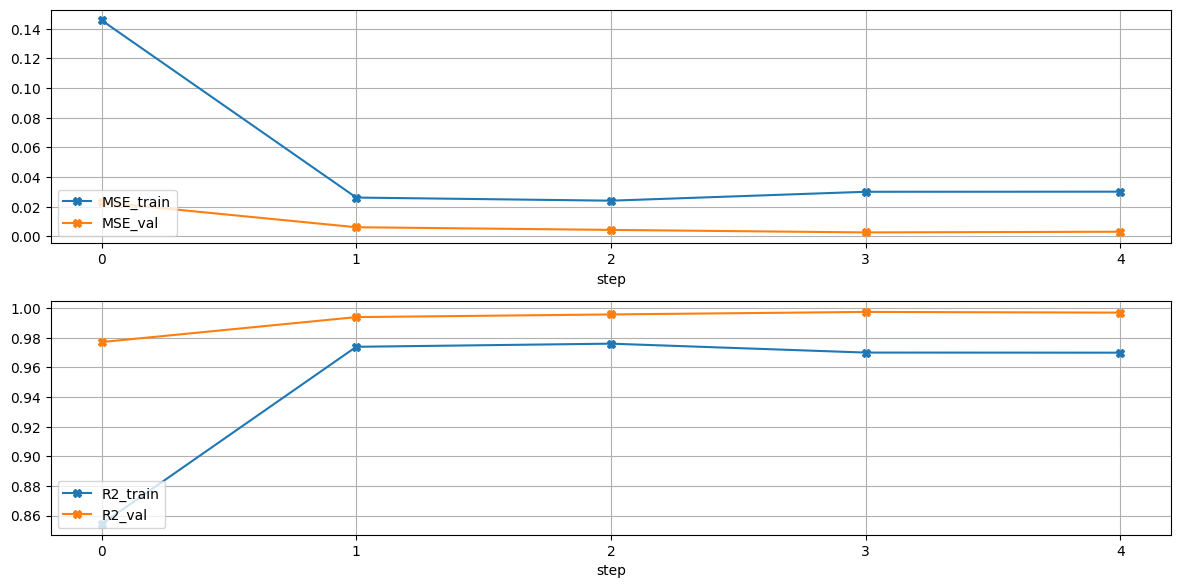

Epoch 00042: reducing learning rate of group 0 to 1.0000e-04.


In [ ]:
from neural_ml import train_mlp

param_names = ['M1 Eigenfrequency (Hz)']
plot_param = 'M1 Eigenfrequency (Hz)'
num_epochs = 50

model_mlp = FCNetwork().to(device)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)
pp_mlp = train_mlp(model_mlp, train_loader, val_loader, 
                   criterion, optimizer, scheduler,
                   num_epochs, param_names, plot_param)

Проверка на тестовом датасете:

In [ ]:
from neural_ml import get_readable_metrics_mlp

print(get_readable_metrics_mlp(model=model_mlp, data_loader=test_loader, param_names=param_names))

{'M1 Eigenfrequency (Hz)': [0.004204047378152609, 0.9956914186477661]}


Оценка времени работы нейросетевой модели:

In [ ]:
from neural_ml import get_elapsed_time_mlp

print(get_elapsed_time_mlp(model=model_mlp, data_loader=train_loader, num_samples=200))

0.0049896240234375


# Тандем нейросетей

### Сборка inverse-модели:

In [ ]:
class InverseFC(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=num_pars_y, out_features=200, bias=False),
            nn.BatchNorm1d(num_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=1000, bias=False),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=num_pars_x, bias=True),
        )
    
    def forward(self, x):
        out = self.network(x)
        return out
    
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

### Сборка inverse-модели с условием:

In [ ]:
class CondInverseFC(nn.Module):
    def __init__(self):
        super().__init__()
        self.network_var = nn.Sequential(
            nn.Linear(in_features=num_pars_y, out_features=200, bias=False),
            nn.BatchNorm1d(num_features=200),
            nn.ReLU(),
        )

        self.network_fix = nn.Sequential(
            nn.Linear(in_features=200 + 4, out_features=1000, bias=False),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=num_pars_x, bias=True),
        )
    
    def forward(self, y, x_fix):
        out = self.network_var(y)

        out = torch.cat((out, x_fix), dim=1)

        out = self.network_fix(out)

        out[:, -4:] = x_fix
        
        return out
    
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

### Обучение "безусловного" тандема

Обратите внимание: если вы выберете `plot_param` из X-данных, то пойдет отрисовка графиков обучения именно по этому параметру. К тому же, шедуллер будет корректировать `lr` согласно MSE-ошибке на этом самом параметре.

Также, стоит отметить, что если вы выберете `plot_param` из X-данных, то вы будете отслеживать MSE и R2 на выходе из `model_inverse` (это, простым языком, "стык" двух моделей), а если `plot_param` $\in$ Y-данным, то будете отслеживать MSE и R2 на выходе `model_forward`.

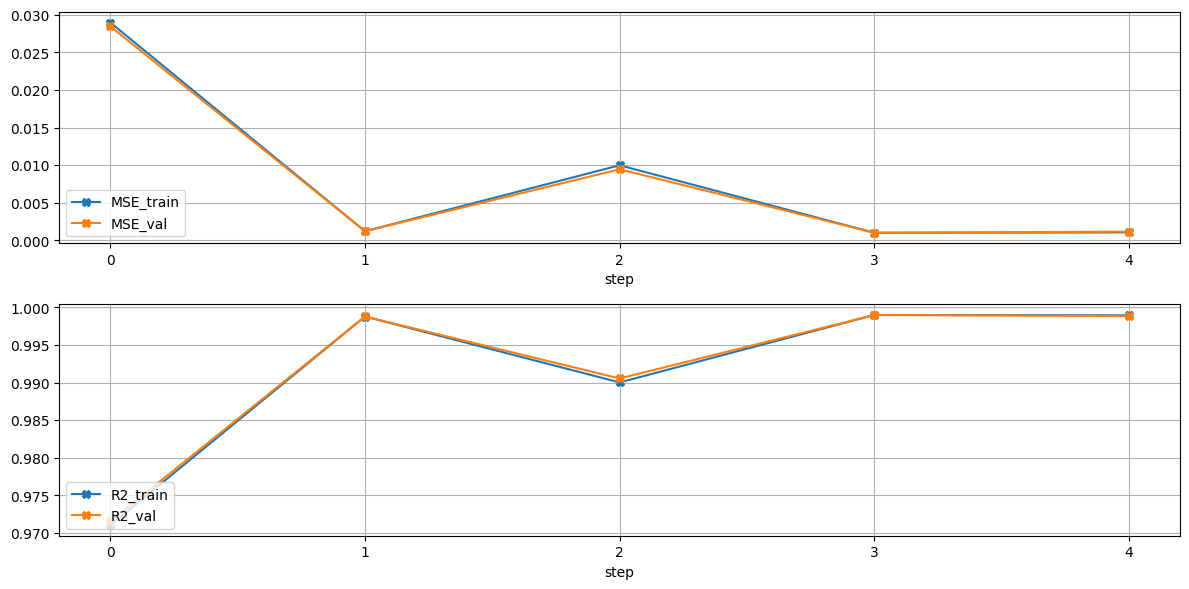

Epoch 00043: reducing learning rate of group 0 to 1.0000e-05.


In [ ]:
from neural_ml import train_tandem

model_inverse = InverseFC().to(device)
model_forward = deepcopy(model_mlp).to(device)
optimizer = torch.optim.Adam(model_inverse.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)

num_epochs = 50
param_names_y = ['M1 Eigenfrequency (Hz)']
pp = train_tandem(model_inverse, model_forward,
                  train_loader, val_loader, 
                  criterion, optimizer, scheduler, 
                  num_epochs, param_names_x=None, param_names_y=param_names_y,
                  plot_param='M1 Eigenfrequency (Hz)')

### Обучение тандема с условием:

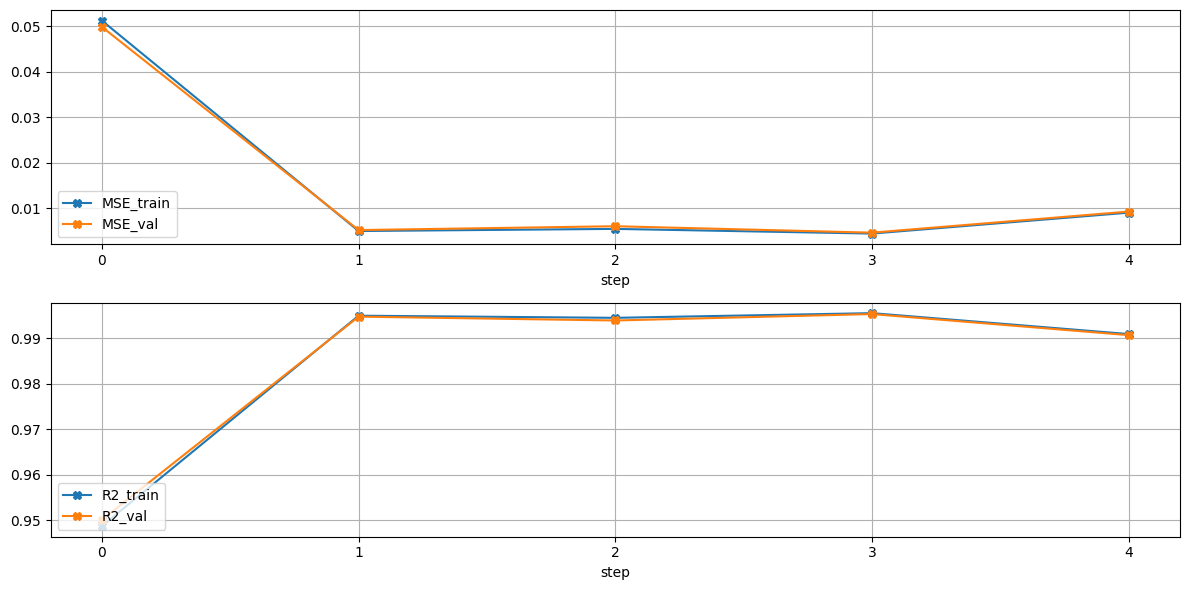

Epoch 00046: reducing learning rate of group 0 to 1.0000e-08.


In [ ]:
from neural_ml import train_tandem_cond

model_inverse = CondInverseFC().to(device)
model_forward = deepcopy(model_mlp).to(device)
optimizer = torch.optim.Adam(model_inverse.parameters(), lr=1e-5)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)

num_epochs = 50
param_names_y = ['M1 Eigenfrequency (Hz)']
pp = train_tandem_cond(model_inverse, model_forward,
                      train_loader, val_loader, 
                      criterion, optimizer, scheduler, 
                      num_epochs, param_names_x=None, param_names_y=param_names_y,
                      plot_param='M1 Eigenfrequency (Hz)')

# Тестирование

Тест "безусловного" тандема:

In [ ]:
param_list = [2.166e6]
y_real = pd.DataFrame([param_list])
y_real.columns = y_train.columns
print(y_real)

y_real = s.transform_real_y(y_real)
print(y_real)
y_real_torch = torch.tensor(y_real.iloc[:, :].values, dtype=torch.float32).to(device)

# Подаем реальные данные на вход инверсной модели
with torch.no_grad():
    x_real_pred = model_inverse(y_real_torch)
x_real_pred = pd.DataFrame(x_real_pred.detach().cpu().numpy())
print(x_real_pred)

x_real_pred, y_real = s.reverse_transform(x_real_pred, y_real, concat_required=False)
x_real_pred = pd.DataFrame(x_real_pred)
x_real_pred.columns = x_train.columns

real_pred = pd.concat([x_real_pred, y_real], axis=1)
real_pred.head()

   M1 Eigenfrequency (Hz)
0               2166000.0
   M1 Eigenfrequency (Hz)
0               -0.135679
          0         1       2         3         4         5         6  \
0  0.182229 -0.260083  0.1715  0.582095 -0.486189  0.602359  0.548369   

          7  
0  0.401651  


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz)
0,122.647598,458.643677,158.306015,37.233894,0.669653,435.90274,24.165113,597590720.0,2166000.0


Тест условного тандема:

In [ ]:
param_list = [2.166e6]
y_real = pd.DataFrame([param_list])
y_real.columns = y_train.columns

y_real = s.transform_real_y(y_real)
y_real_torch = torch.tensor(y_real.iloc[:, :].values, dtype=torch.float32).to(device)

x_fix = pd.DataFrame([[1, 1, 1, 1, 1, 600, 0, 0]])
x_fix.columns = x_train.columns
x_fix = s.transform_real_x(x_fix)
x_fix = torch.tensor(x_fix.iloc[:, -4:].values, dtype=torch.float32).to(device)

# Подаем реальные данные на вход инверсной модели
with torch.no_grad():
    x_real_pred = model_inverse(y_real_torch, x_fix)
x_real_pred = pd.DataFrame(x_real_pred.detach().cpu().numpy())
print(x_real_pred)

x_real_pred, y_real = s.reverse_transform(x_real_pred, y_real, concat_required=False)
x_real_pred = pd.DataFrame(x_real_pred)
x_real_pred.columns = x_train.columns

real_pred = pd.concat([x_real_pred, y_real], axis=1)
real_pred.head()

          0         1         2         3         4         5         6  \
0 -0.192717  0.063627  0.714892  0.494484 -0.331971  1.723854 -1.339507   

          7  
0 -1.461719  


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz)
0,77.150124,546.622925,181.091599,36.2108,1.0,600.0,8.514876e-07,14.848544,2166000.0


В реальном эксперименте такой резонансной частоте соответствует длина нанопровода $L = 70$ мкм.